In [1]:
!nvidia-smi

Mon Sep 25 02:49:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:07:00.0  On |                  N/A |
| 37%   42C    P3    26W / 170W |    729MiB / 12288MiB |     19%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#Load libraries
import time
import os
import copy

import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torcheval.metrics import BinaryConfusionMatrix
import torch.optim as optim
from torch.autograd import Variable
import torchvision


import mlflow
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

import matplotlib.pyplot as plt

import imageio
from PIL import Image 
import cv2

In [3]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
if str(device) == "cuda":
    print("The execution will be on the GPU!")
else:
    print("The execution will be on the CPU!")

The execution will be on the GPU!


# Download dataset

In [5]:
!apt install git -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.17.1-1ubuntu0.18).
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


In [6]:
!git clone https://github.com/lucascsfaria/amazonwildroadsdataset.git

fatal: destination path 'amazonwildroadsdataset' already exists and is not an empty directory.


In [7]:
ls amazonwildroadsdataset

README.md  areas/  geojson_line/  image_geotif/  image_png/  mask/


# Parameters Initialization

In [8]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "amazonwildroadsdataset/"

MODELS_PATH = "./models/CRI/"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception, ViT, convnext, swin]
model_name = "resnet"

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 2

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

lr=0.0001 
momentum=0.9

num_classes = 1

# Patch size
tam = 128
# Patch shift
stride = 64

OUTPUT_PATH = "./output/PRE/"+model_name

## MLFlow Initialization

In [9]:
# Import the MLFlow package and select the path that will store the data files (If the folder does not exist, MLFlow will create the structures)
mlflow.set_tracking_uri("file:///user/home/Lucas/MLFlow2/")

In [10]:
# Creates an experiment with name "ContextualRoadIndicator" if it does not exist and returns the ID. If it already exists, returns the ID.
experiment = "ContextualRoadIndicator"

try:
    idExperiment = mlflow.create_experiment(experiment)
except:
    idExperiment = mlflow.get_experiment_by_name(experiment).experiment_id

## Create Road Dataset Classification for Contextual Road Indicator (CRI)

In [11]:
path_images_png = os.path.join(data_dir, 'image_png')
path_mask_png = os.path.join(data_dir, 'mask')

images_filenames = os.listdir(path_images_png)
images_mask_filenames = os.listdir(path_mask_png)

In [12]:
if len(images_filenames) != len(images_mask_filenames):
    print("Number of images does not correspond to the number of masks!")

In [13]:
dataset_images_crop = [] 


for filename in images_filenames:
    im = cv2.imread(os.path.join(path_images_png,filename))
    mask = Image.open(os.path.join(path_mask_png,filename)).convert('L')
    
    width, height = mask.size
    x_init = y_init = 0
    cont_part = 0
    
    print(filename)

    while x_init+tam<=width:
        y_init = 0
        while y_init+tam <=height:
            croppedMask = mask.crop((x_init, y_init, x_init+tam, y_init+tam))
            croppedIm = im[y_init:y_init+tam, x_init:x_init+tam]
            np_img = np.array(croppedMask)
            np_non_zero = np.count_nonzero(np_img)

            if np_non_zero == 0:
                image_data = {
                    "label": 0,
                    "image": croppedIm,
                    "name_image": filename,
                    "coordinate": (x_init, y_init)
                }
            else:
                image_data = {
                    "label": 1,
                    "image": croppedIm,
                    "name_image": filename,
                    "coordinate": (x_init, y_init)
                }
            dataset_images_crop.append(image_data)
            cont_part+=1
            y_init+=stride
        x_init+=stride
    

PA1.png
PA2.png
PA5.png
PA12.png
MT1.png
RR2.png
MT3.png
AM4.png
AC2.png
PA11.png
AM2.png
PA10.png
AC1.png
RO1.png
PA7.png
PA9.png
AM1.png
AM6.png
PA3.png
PA8.png
RR1.png
AM5.png
TO1.png
AM7.png
MT2.png
AM3.png
PA4.png
PA6.png


In [14]:
class RoadClassificationDataset(Dataset):
    def __init__(self, list_images, transform=None):
        self.list_images = list_images
        self.transform = transform

    def __len__(self):
        return len(self.list_images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        
        image = self.list_images[idx]["image"]
        label = torch.tensor(self.list_images[idx]["label"])
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [15]:
train_filenames = ["PA1.png",
                   "PA8.png",
                   "PA5.png",
                   "PA12.png",
                   "MT1.png",
                   "RR2.png",
                   "MT3.png",
                   "AM4.png",
                   "PA11.png",
                   "AM2.png",
                   "PA10.png",
                   "PA7.png",
                   "AM1.png",
                   "PA3.png",
                   "RR1.png",
                   "AM5.png",
                   "TO1.png",
                   "MT2.png",
                   "PA4.png",
                   "PA6.png"]
test_filenames = ["AM3.png",
                  "AM7.png",
                  "AC1.png",
                  "AC2.png",
                  "AM6.png",
                  "RO1.png",
                  "PA2.png",
                  "PA9.png"]

In [16]:
# If you want to randomly separate between training and testing sets, uncomment this line
#train_filenames, test_filenames = train_test_split(images_filenames, test_size=0.2, random_state=3)

dataset_images = {}
dataset_images["train"] = [im for im in dataset_images_crop if im['name_image'] in train_filenames]
dataset_images["val"] = [im for im in dataset_images_crop if im['name_image'] in test_filenames]

In [17]:
print("Quantidade de amostras da classe sem estradas: ")
print(len([im for im in dataset_images_crop if im['label'] == 0]))
print("Quantidade de amostras da classe com estradas: ")
print(len([im for im in dataset_images_crop if im['label'] == 1]))

Quantidade de amostras da classe sem estradas: 
13024
Quantidade de amostras da classe com estradas: 
4616


## Model preparation

In [18]:
def calculate_metrics(TP, TN, FP, FN):
    
    sensitivity = TP / (TP + FN)
    
    specificity = TN / (TN + FP)
    
    accuracy = (TP + TN) / (TP+FN+FP+TN)
    
    recall= TP / (TP+FN)
    
    precision = TP/(TP + FP)
    
    baccuracy = (sensitivity + specificity) / 2
        
    F1_score = 2 * ((precision * recall) / (precision + recall))
    

    metrics = {'f1_score':F1_score,'accuracy':accuracy,'balanced_accuracy':baccuracy, 'precision': precision, 'recall': recall}
    return metrics

In [19]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            metric = BinaryConfusionMatrix()
            metric.to(device)

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels_old = labels
                labels_old = labels_old.to(device)
                labels = labels.unsqueeze(1).float()
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        #_, preds = torch.max(outputs, dim=1)
                        #preds = preds.type(torch.FloatTensor).reshape((preds.shape[0], 1))
                        #preds = torch.tensor(preds, requires_grad = True).to(device)
                        #print(outputs)
                        #print(labels)
                        
                        loss = criterion(outputs, labels)
                    
                    

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                #print(outputs.sigmoid().squeeze(1))
                #print(labels_old)
                metric.update(outputs.sigmoid().squeeze(1), labels_old)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            mat_conf = metric.compute()
            mat_conf_np = mat_conf.cpu().numpy()
            tp_temp, fn_temp, fp_temp, tn_temp = mat_conf_np.ravel()
            
            metrics_calculed = calculate_metrics(tp_temp, tn_temp, fp_temp, fn_temp)

            print('{} Loss: {:.4f} Acc_Balanced: {:.4f}'.format(phase, epoch_loss, metrics_calculed["balanced_accuracy"]))

            mlflow.log_metric(phase+"_epoch_loss", float(epoch_loss), step=epoch)
            for key in metrics_calculed:
                mlflow.log_metric(phase+"_"+key, metrics_calculed[key], step=epoch)


            # deep copy the model
            if phase == 'val' and metrics_calculed["balanced_accuracy"] > best_acc:
                best_acc = metrics_calculed["balanced_accuracy"]
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(),os.path.join(MODELS_PATH, model_name+"-"+'best_checkpoint.model'))
            if phase == 'val':
                val_acc_history.append(metrics_calculed["balanced_accuracy"])

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    mlflow.log_metric("best_acc", float(best_acc))
    mlflow.log_artifact(os.path.join(MODELS_PATH, model_name+"-"+'best_checkpoint.model'))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [20]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [21]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(weights=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(weights=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(weights=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(weights=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(weights=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224
    
    elif model_name == "ViT":
        """ ViT
        """
        model_ft = models.vit_b_16(weights = models.ViT_B_16_Weights.IMAGENET1K_V1)
        print(model_ft)
        set_parameter_requires_grad(model_ft, feature_extract)
        #num_ftrs = model_ft.fc.in_features
        model_ft.heads.head = nn.Linear(768, num_classes)
        input_size = 224
        
    elif model_name == "convnext":
        """ convnext
        """
        model_ft = models.convnext_base(weights = models.ConvNeXt_Base_Weights.IMAGENET1K_V1)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[2].in_features
        model_ft.classifier[2] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "swin":
        """ swin
        """
        model_ft = models.swin_v2_b(weights = models.Swin_V2_B_Weights.IMAGENET1K_V1)
        print(model_ft)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.head = nn.Linear(1024, num_classes)
        input_size = 256

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(weights=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(1024,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Dataset preparation for training

In [22]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=(0, 359)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(input_size),
        #transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: RoadClassificationDataset(dataset_images[x], data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


## Load Model with loss and optimizer

In [23]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=lr, momentum=momentum)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

## Train model

In [24]:
if not os.path.isdir(MODELS_PATH):
    os.makedirs (MODELS_PATH)

# Setup the loss fxn
#weights = torch.tensor([0.8, 0.2]).to(device)
#criterion = nn.CrossEntropyLoss(weight=weights)
criterion = nn.BCEWithLogitsLoss()

# Train and evaluate
with mlflow.start_run(experiment_id=idExperiment, run_name=model_name):

  mlflow.log_param("data_dir", data_dir)
  mlflow.log_param("model_name", model_name)
  mlflow.log_param("batch_size", batch_size)
  mlflow.log_param("num_epochs", num_epochs)
  mlflow.log_param("learning_rate", lr)
  mlflow.log_param("momentum", momentum)

  model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))



Epoch 0/1
----------
train Loss: 0.4575 Acc_Balanced: 0.6760
val Loss: 0.4119 Acc_Balanced: 0.7378

Epoch 1/1
----------
train Loss: 0.3909 Acc_Balanced: 0.7605
val Loss: 0.4064 Acc_Balanced: 0.7382

Training complete in 1m 46s
Best val Acc: 0.738184


In [25]:
loader = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

def image_loader(image):
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

def predict_patch(model_ft, image):
  image = image_loader(image)

  model_ft.eval()
  output = model_ft(image)

  sm = torch.nn.Sigmoid()

  probabilities = sm(output) 


  result = probabilities.cpu().detach().numpy()

  return result[0]



In [26]:
def toImgOpenCV(imgPIL): # Conver imgPIL to imgOpenCV
    i = np.array(imgPIL) # After mapping from PIL to numpy : [R,G,B,A]
                         # numpy Image Channel system: [B,G,R,A]
    red = i[:,:,0].copy(); i[:,:,0] = i[:,:,2].copy(); i[:,:,2] = red;
    return i; 

def toImgPIL(imgOpenCV): return Image.fromarray(cv2.cvtColor(imgOpenCV, cv2.COLOR_BGR2RGB));

In [27]:
if not os.path.isdir(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    os.makedirs(os.path.join(OUTPUT_PATH, "mask"))
    os.makedirs(os.path.join(OUTPUT_PATH, "heatmap"))
    os.makedirs(os.path.join(OUTPUT_PATH, "heatmap_np"))

In [28]:
OUTPUT_PATH

'predict_all_dataset_asfd/resnet'

AM3.png


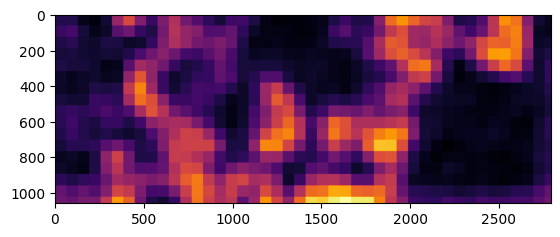

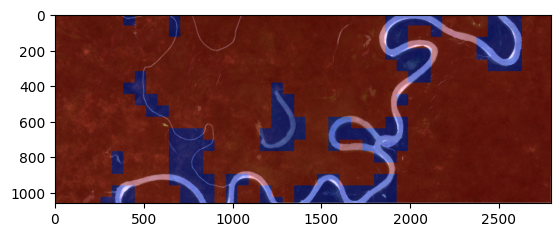

AM7.png


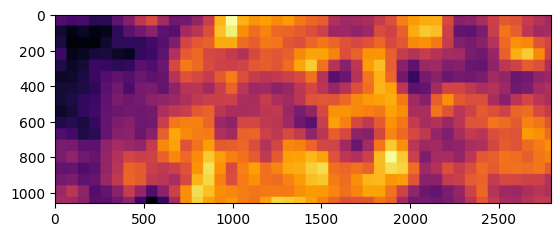

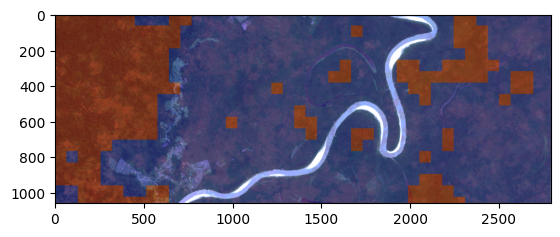

AC1.png


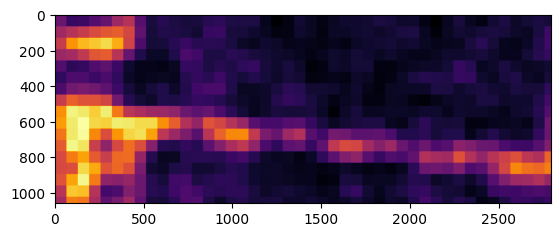

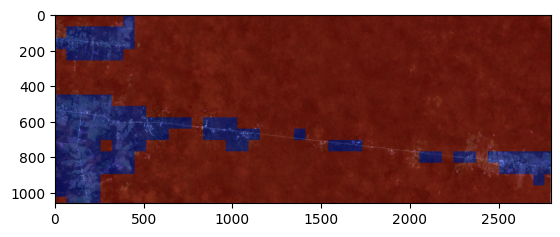

AC2.png


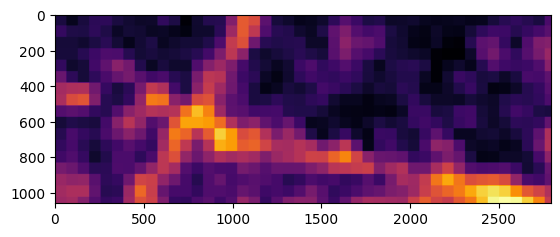

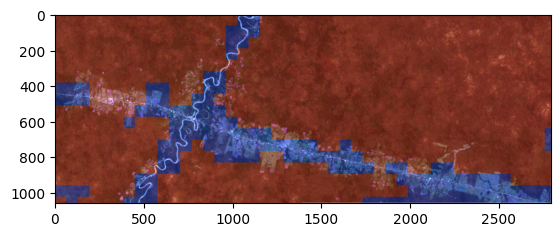

AM6.png


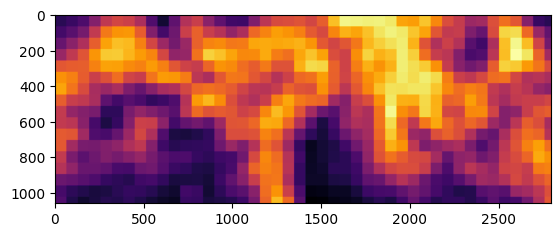

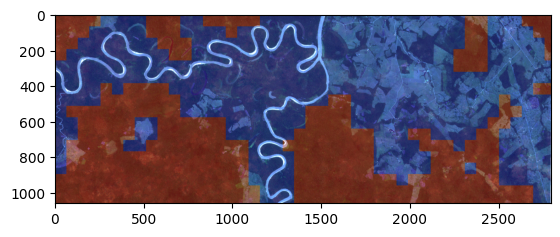

RO1.png


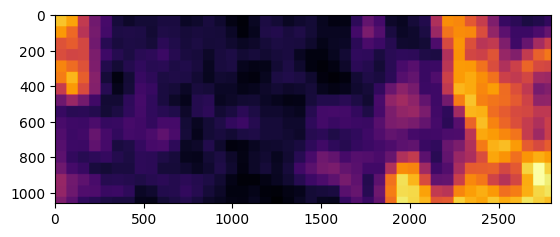

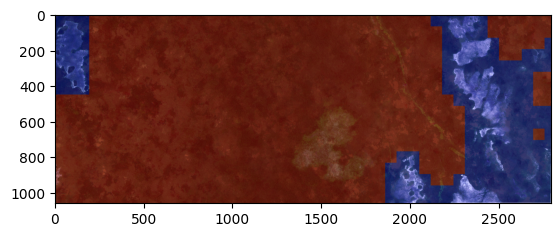

PA2.png


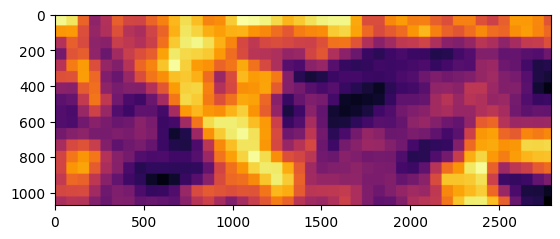

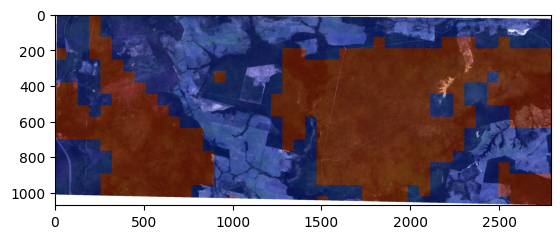

PA9.png


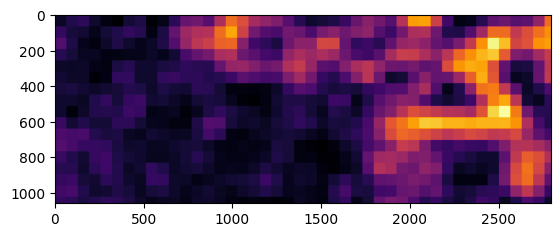

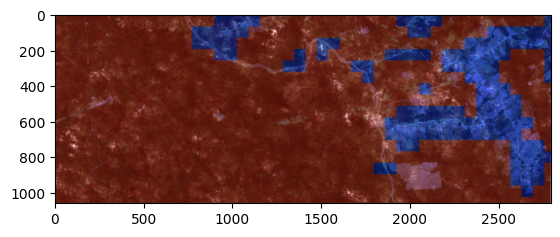

In [29]:
y_true = []
y_pred = []

for image_filename in test_filenames:
    print(image_filename)
    x_init = y_init = 0
    
    path_filename = os.path.join(data_dir, os.path.join("image_png", image_filename))
    path_filename_mask = os.path.join(data_dir, os.path.join("mask", image_filename))

    im = cv2.imread(path_filename)
    mask = cv2.imread(path_filename_mask)

    reflect = cv2.copyMakeBorder(im,tam,tam,tam,tam,cv2.BORDER_REFLECT)
    im = toImgPIL(reflect)

    reflect = cv2.copyMakeBorder(mask,tam,tam,tam,tam,cv2.BORDER_REFLECT)
    mask = toImgPIL(reflect)

    width, height = im.size

    heatmap = np.zeros([height,width], dtype = np.float32)

    while x_init+tam<=width:
      #print("x_init", x_init+tam)
      y_init = 0
      while y_init+tam <=height:
        #print("y_init", y_init+tam)
        im_cropped = im.crop((x_init, y_init, x_init+tam, y_init+tam))
        #im_cropped.save(os.path.join(OUTPUT_PATH, "im_cropped.png"))

        croppedMask = mask.crop((x_init, y_init, x_init+tam, y_init+tam))
        np_img = np.array(croppedMask)
        np_non_zero = np.count_nonzero(np_img)

        if np_non_zero == 0:
          y_true.append(0)
        else:
          y_true.append(1)


        result = predict_patch(model_ft, im_cropped)

        if result < 0.5:
          y_pred.append(0)
        else:
          y_pred.append(1)

        heatmap[y_init:y_init+tam,x_init:x_init+tam] += result

        y_init+=stride
      x_init+=stride

    heatmap = heatmap[tam:height-tam,tam:width-tam] 
    plt.imshow(heatmap, cmap='inferno')
    plt.show()
    
    imagea = (heatmap/np.amax(heatmap))
    imagea = np.uint8(imagea * 255)


    image_mask = imagea
    image_mask[imagea>=128] = 255
    image_mask[imagea<128] = 0
    image_mask = Image.fromarray(image_mask, 'L')
    image_mask.save(os.path.join(OUTPUT_PATH, os.path.join("mask",image_filename)))

    img = Image.fromarray(imagea, 'L')
    img_heatmap = np.uint8(img)


    img_heatmap = cv2.applyColorMap(img_heatmap, cv2.COLORMAP_JET)
    cv2.imwrite(os.path.join(OUTPUT_PATH, os.path.join("heatmap_np", image_filename)), img_heatmap)

    img = cv2.imread(path_filename)
    super_imposed_img = cv2.addWeighted(img_heatmap, 0.6, img, 1, 0)
    cv2.imwrite(os.path.join(OUTPUT_PATH, os.path.join("heatmap", image_filename)), super_imposed_img)
    plt.imshow(super_imposed_img)
    plt.show()

In [30]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      5533
           1       0.43      0.61      0.50      1459

    accuracy                           0.75      6992
   macro avg       0.66      0.70      0.67      6992
weighted avg       0.79      0.75      0.76      6992

